# DAS - UE1 - Teil 1 - Brunner Michael - se21m021

# Import necessary dependencies

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from scipy.io import arff

import seaborn as sns

from pandas.plotting import parallel_coordinates

%matplotlib inline

# Load and merge datasets

In [133]:
data = arff.loadarff('.\\data\\Transplant\\bone-marrow.arff')

transplants = pd.DataFrame(data[0])

transplants = transplants.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
transplants.dropna(inplace=True)
clean_transplants = transplants
for col in transplants.columns:
    clean_transplants = clean_transplants[clean_transplants[col] != '?']

transplants = clean_transplants
#This would shuffle the dataset
#transplants = transplants.sample(frac=1, random_state=42).reset_index(drop=True)

survival_status_dict = {1: 'dead', 0: 'alive'}
Recipientgender_dict = {1: 'male', 0: 'female'}
Stemcellsource = {1: 'Peripheral blood', 0: 'Bone marrow'}
IIIV_dict = {1: 'Yes', 0: 'No'}
Gendermatch = {1: 'Female to Male', 0: 'Other'}
RecipientRh = {1: "+", 0: '-'}

Disease_dict = {'ALL' : 0,'AML' : 1,'chronic' : 2,'nonmalignant' : 3,'lymphoma' : 4}

transplants['survival_status'] = transplants['survival_status'].map(survival_status_dict)
transplants['Disease'] = transplants['Disease'].map(Disease_dict)

# Show dataset features and values

In [134]:
transplants.head()

Recipientgender Stemcellsource   Donorage Donorage35 IIIV Gendermatch  \
0               1              1  22.830137          0    1           0   
1               1              0  23.342466          0    1           0   
2               1              0  26.394521          0    1           0   
4               0              1  33.358904          0    0           0   
8               1              1  32.641096          0    0           0   

  DonorABO RecipientABO RecipientRh ABOmatch  ... extcGvHD CD34kgx10d6  \
0        1            1           1        0  ...        1        7.20   
1       -1           -1           1        0  ...        1        4.50   
2       -1           -1           1        0  ...        1        7.94   
4        1            2           0        1  ...        1       51.85   
8        2            0           1        1  ...        1       23.54   

    CD3dCD34  CD3dkgx10d8 Rbodymass ANCrecovery PLTrecovery  \
0   1.338760         5.38      35.0        19.0        51.0   
1  11.078295         0.41      20.6        16.0        37.0   
2  19.013230         0.42      23.4        23.0        20.0   
4   3.972255        13.05       9.0        14.0        14.0   
8   3.772555         6.24      20.5        15.0        14.0   

  time_to_aGvHD_III_IV survival_time survival_status  
0                 32.0         999.0           alive  
1            1000000.0         163.0            dead  
2            1000000.0         435.0            dead  
4            1000000.0        2043.0           alive  
8            1000000.0         671.0           alive  

[5 rows x 37 columns]

In [135]:
len(transplants.index)

142

# PCA

To reduce dimensions I first tried to use PCA. I tried to reduce the 37 dimensions of the original dataset to only 7.

In [136]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

transplants_without_survival_statistics = transplants.drop(['survival_status', 'survival_time'], axis=1)

scaled_features = sc.fit_transform(transplants_without_survival_statistics.values)
scaled_features_df = pd.DataFrame(scaled_features, index=transplants_without_survival_statistics.index, columns=transplants_without_survival_statistics.columns)

n_components = 7
pca = PCA(n_components=n_components)

pca.fit(scaled_features_df)

pca_df = pd.DataFrame(pca.transform(scaled_features_df), columns=['PCA%i' % i for i in range(n_components)], index=scaled_features_df.index)
pca_df = pd.concat([pca_df, transplants.survival_time, transplants.survival_status], axis=1)
pca_df.head()

PCA0      PCA1      PCA2      PCA3      PCA4      PCA5      PCA6  \
0 -0.824860 -1.353217  1.982912 -0.785221  3.631261  0.607501  0.495485   
1 -1.477314 -1.660504  2.696664  3.054943 -1.296637 -1.408710  0.572723   
2 -2.424127 -1.481734  1.501386  4.036479  0.627401 -0.535825  0.542011   
4  4.008983 -2.130804 -1.204412 -0.581395 -0.889597 -0.494835 -0.017119   
8  0.219523 -3.062067 -1.658552 -1.153600 -0.272897 -1.215127  0.336972   

   survival_time survival_status  
0          999.0           alive  
1          163.0            dead  
2          435.0            dead  
4         2043.0           alive  
8          671.0           alive

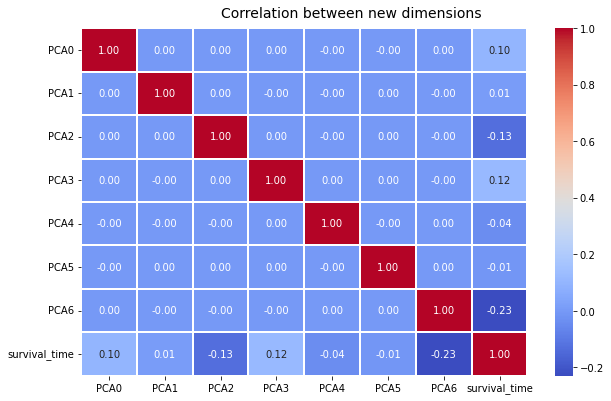

In [137]:
f, ax = plt.subplots(figsize=(10, 6))
corr = pca_df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
            linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Correlation between new dimensions', fontsize=14)

The correlation between the PCA components is very low. This is expected as we wanted to separate the dimensions into components that don't correlate with each other and explain the maximum amount of variance.


# LDA

Next, I tried to use LDA next, as it aims to maximise variance between the classes (e.g. survival_status)

In [138]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

n_components=1

lda = LinearDiscriminantAnalysis(n_components=n_components, solver="svd")

#transplants_without_survival_statistics = transplants.drop(['survival_status', 'survival_time'], axis=1)

lda.fit(transplants_without_survival_statistics, transplants['survival_status'].values)

lda_df = pd.DataFrame(lda.transform(transplants_without_survival_statistics), columns=['LDA%i' % i for i in range(n_components)], index=transplants_without_survival_statistics.index)
lda_df = pd.concat([lda_df, transplants.survival_time, transplants.survival_status], axis=1)
lda_df.head()

LDA0  survival_time survival_status
0 -0.442881          999.0           alive
1  1.404945          163.0            dead
2  2.319715          435.0            dead
4 -1.543817         2043.0           alive
8 -0.181114          671.0           alive

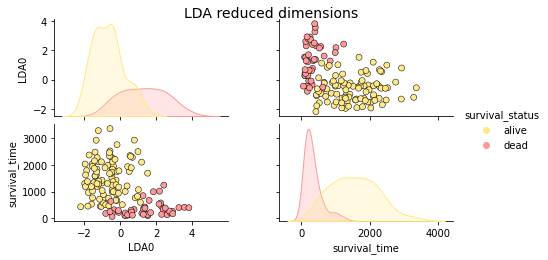

In [139]:
pp = sns.pairplot(lda_df, hue='survival_status', height=1.8, aspect=1.8,
                  palette={"dead": "#FF9999", "alive": "#FFE888"},
                  plot_kws=dict(edgecolor="black", linewidth=0.5))
fig = pp.fig
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('LDA reduced dimensions', fontsize=14)



<AxesSubplot:xlabel='LDA0', ylabel='survival_time'>

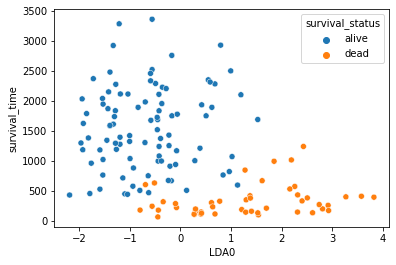

In [140]:
sns.scatterplot(data=lda_df, x="LDA0", y="survival_time", hue="survival_status")

This results in a rather good separation.

Next I tried the same algorithm with different parameters.
I switched from using 'single value decomposition' to the 'eigenvalue decomposition for the solver algorithm.
Furthermore, I set the shrinkage method to using Ledoit-Wolf estimator. This should improve the separation for better classification later.

<AxesSubplot:xlabel='LDA0', ylabel='survival_time'>

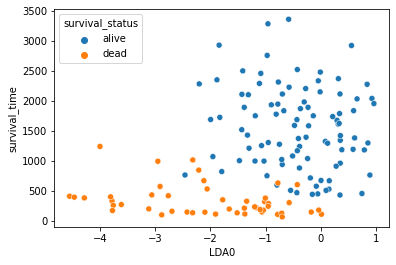

In [141]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

n_components=1

lda = LinearDiscriminantAnalysis(n_components=n_components, solver="eigen", shrinkage="auto")

#transplants_without_survival_statistics = transplants.drop(['survival_status', 'survival_time'], axis=1)

lda.fit(transplants_without_survival_statistics, transplants['survival_status'].values)

lda_df = pd.DataFrame(lda.transform(transplants_without_survival_statistics), columns=['LDA%i' % i for i in range(n_components)], index=transplants_without_survival_statistics.index)
lda_df = pd.concat([lda_df, transplants.survival_time, transplants.survival_status], axis=1)
lda_df.head()

sns.scatterplot(data=lda_df, x="LDA0", y="survival_time", hue="survival_status")

# T-sne

Next I used t-sne to reduce dimensions
Because T-SNE is non-deterministic I fitted the model 5 times.

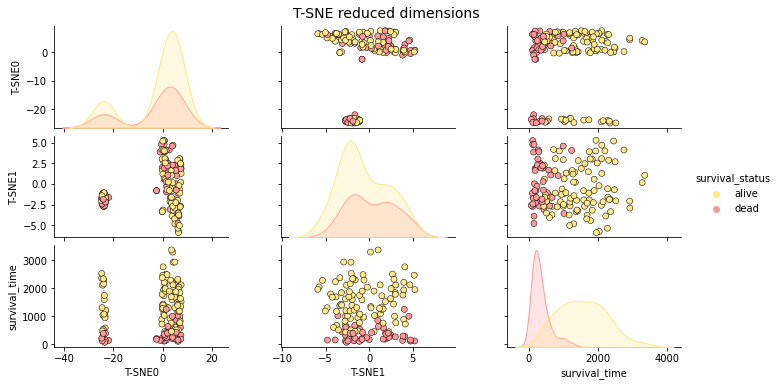

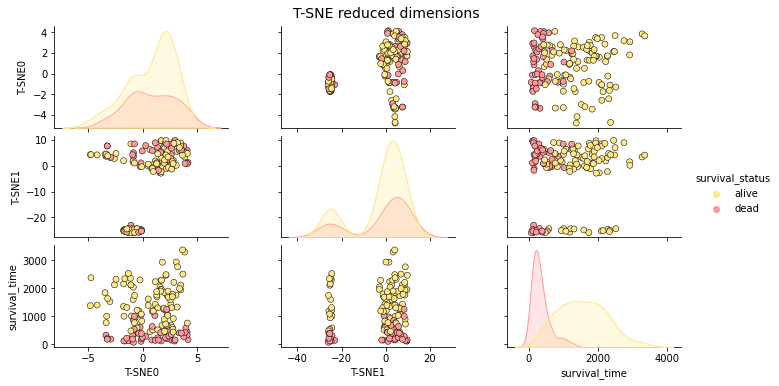

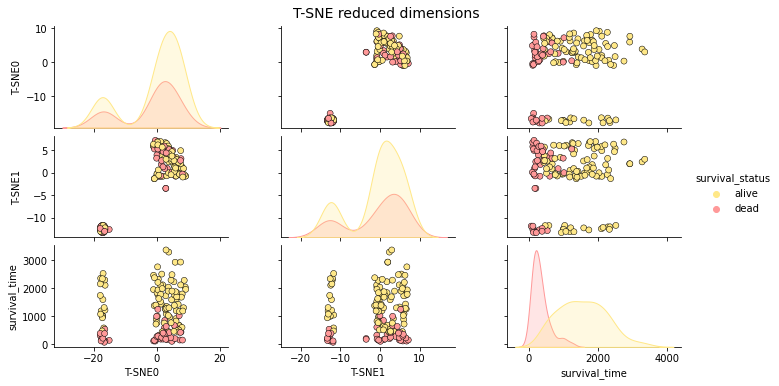

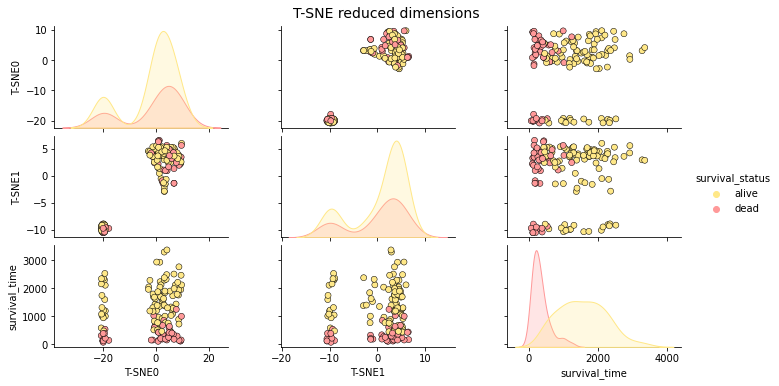

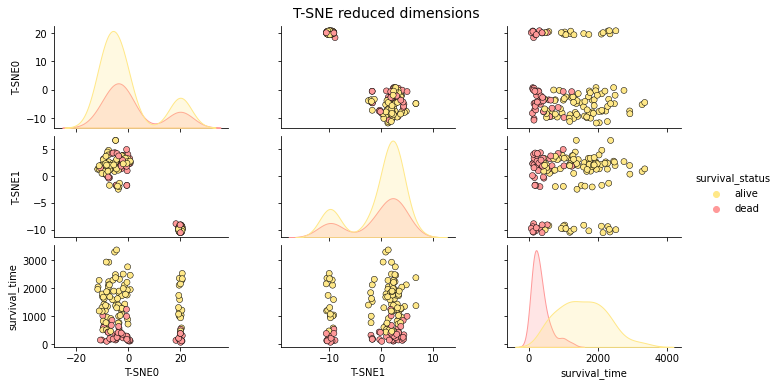

In [142]:
from sklearn.manifold import TSNE

n_components = 2

for i in range(5):
    tsne = TSNE(n_components=n_components, learning_rate='auto', init='random')
    tsne_df = pd.DataFrame(tsne.fit_transform(transplants_without_survival_statistics), columns=['T-SNE%i' % i for i in range(n_components)], index=transplants_without_survival_statistics.index)
    tsne_df = pd.concat([tsne_df, transplants.survival_time, transplants.survival_status], axis=1)
    tsne_df.head()

    pp = sns.pairplot(tsne_df, hue='survival_status', height=1.8, aspect=1.8,
                      palette={"dead": "#FF9999", "alive": "#FFE888"},
                      plot_kws=dict(edgecolor="black", linewidth=0.5))
    fig = pp.fig
    fig.subplots_adjust(top=0.93, wspace=0.3)
    t = fig.suptitle('T-SNE reduced dimensions', fontsize=14)

I then played with the learning-rate (between 200 and 1000)

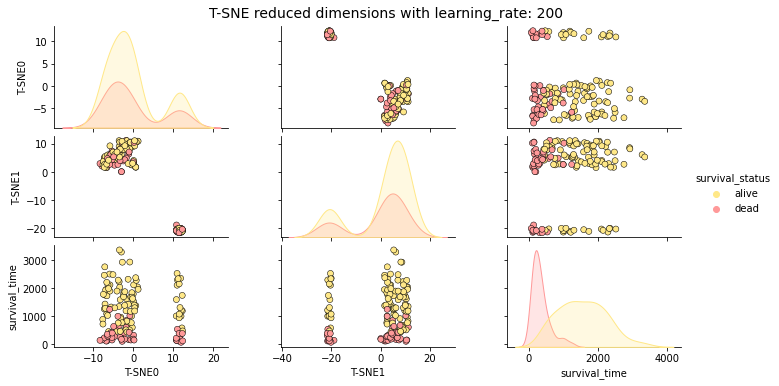

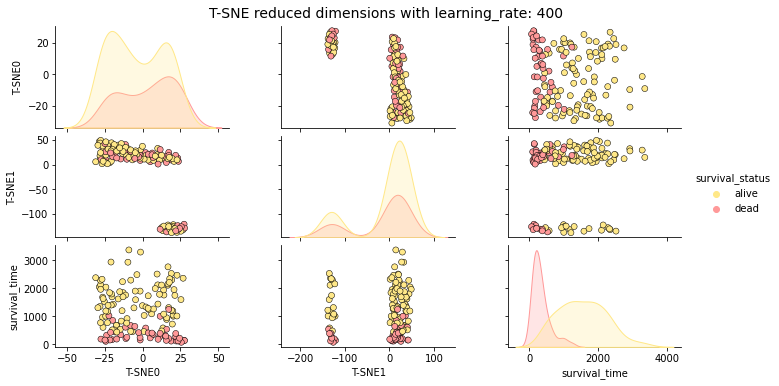

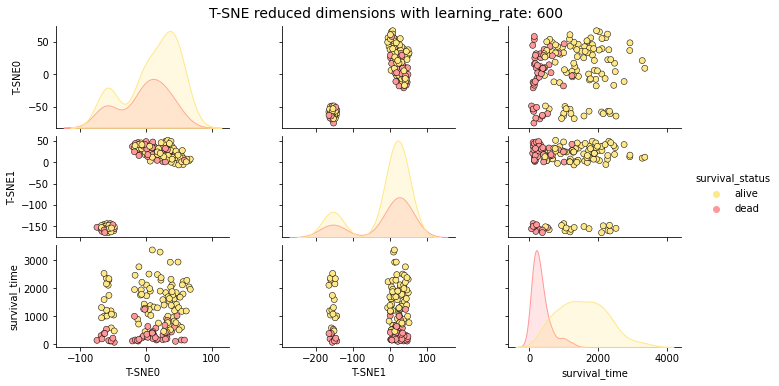

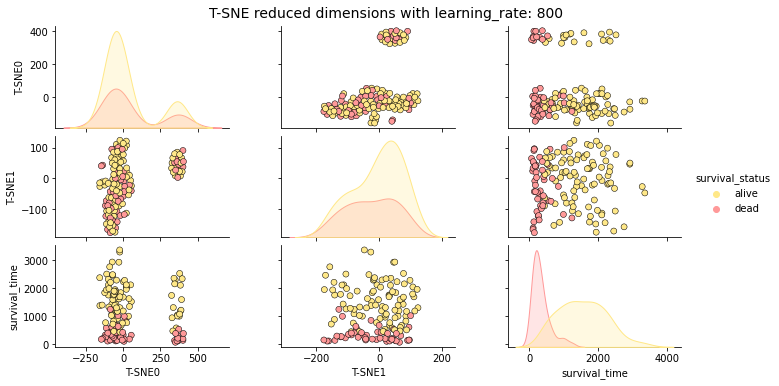

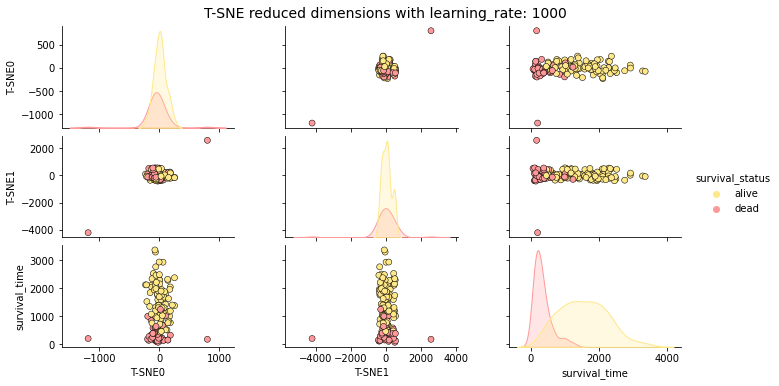

In [143]:
from sklearn.manifold import TSNE

n_components = 2

for i in range(1, 6):
    lr = i * 200
    tsne = TSNE(n_components=n_components, learning_rate=lr, init='random')
    tsne_df = pd.DataFrame(tsne.fit_transform(transplants_without_survival_statistics), columns=['T-SNE%i' % i for i in range(n_components)], index=transplants_without_survival_statistics.index)
    tsne_df = pd.concat([tsne_df, transplants.survival_time, transplants.survival_status], axis=1)
    tsne_df.head()

    pp = sns.pairplot(tsne_df, hue='survival_status', height=1.8, aspect=1.8,
                      palette={"dead": "#FF9999", "alive": "#FFE888"},
                      plot_kws=dict(edgecolor="black", linewidth=0.5))
    fig = pp.fig
    fig.subplots_adjust(top=0.93, wspace=0.3)
    t = fig.suptitle('T-SNE reduced dimensions with learning_rate: ' + str(lr), fontsize=14)

A higher learning-rate results in bigger clouds as expected.

I also wanted to try how the results would be if I used PCA for the initialization.

C:\Users\nixmi\Documents\Dev\FH\MSE2\DAS\EX1\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


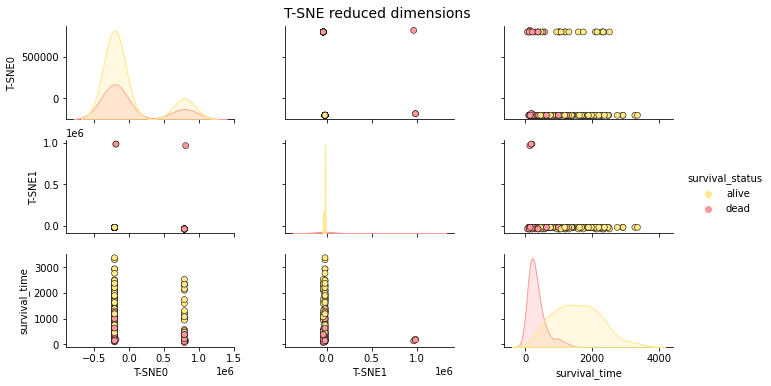

In [144]:
tsne = TSNE(n_components=n_components, learning_rate='auto', init='pca')
tsne_df = pd.DataFrame(tsne.fit_transform(transplants_without_survival_statistics), columns=['T-SNE%i' % i for i in range(n_components)], index=transplants_without_survival_statistics.index)
tsne_df = pd.concat([tsne_df, transplants.survival_time, transplants.survival_status], axis=1)
tsne_df.head()

pp = sns.pairplot(tsne_df, hue='survival_status', height=1.8, aspect=1.8,
                  palette={"dead": "#FF9999", "alive": "#FFE888"},
                  plot_kws=dict(edgecolor="black", linewidth=0.5))
fig = pp.fig
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('T-SNE reduced dimensions', fontsize=14)

This is much more pronounced and far from the clouds that t-sne gave me without initialization.